# IVS OCR model

## `01` Install Libs

In [ ]:
# !pip install torch torchvision torchaudio easyocr

In [15]:
# !rm -rf ~/.EasyOCR
# !pip uninstall easyocr -y
# !pip install easyocr

In [87]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install supervision

`Note`
- One of the problems happened was with cuda and the version of pytourch so the last command installation will fix it 
- Another problem was with the GPU after install using this command so the solution was to restart the session to start over 

## `02` Import Libs

In [102]:
import easyocr
import matplotlib.pyplot as plt
import cv2
import re
import supervision as sv
import numpy as np

In [2]:
import torch
print(torch.cuda.is_available())

False


/home/israa/Desktop/Computer_Vision_Projects/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [80]:
def display_image(image, title="Image", cmap='gray'):
    """
    Display an image using matplotlib.
    
    Parameters:
    - image: The image to display.
    - title: The title of the image.
    - cmap: Color map to use for displaying the image.
    """
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

## `03` Load the image


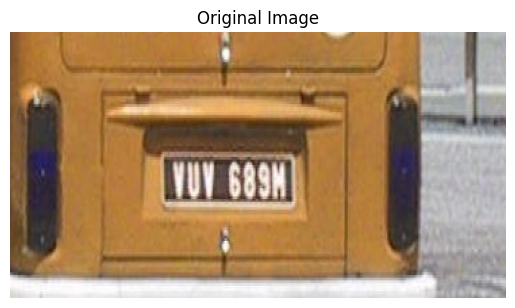

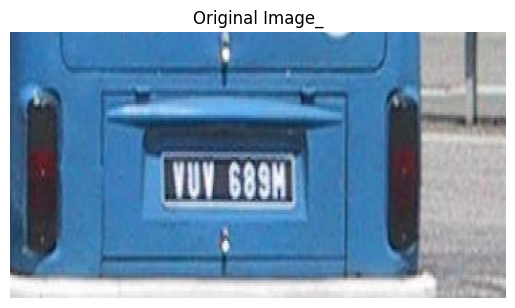

In [90]:
image_path = '/home/israa/Desktop/Computer_Vision_Projects/02_Image_classification_Ex/1.png'  # Replace with your image path
image = cv2.imread(image_path)

display_image(image, title="Original Image")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

display_image(image_rgb, title="Original Image_", cmap='viridis')

## `04` Preprocessing

- Changing the resolution

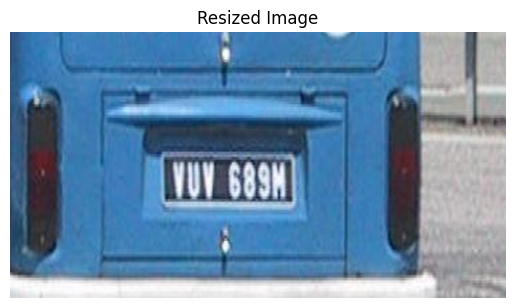

In [91]:
scale_percent = 300  # increase size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
image_resized = cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)

display_image(image_resized, title="Resized Image")

- Grayscale the image

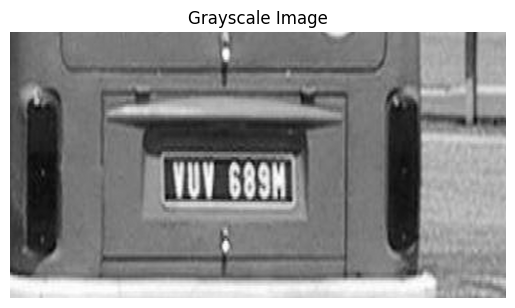

In [92]:
# convert the image to grayscale
image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)

display_image(image_gray, title="Grayscale Image")

- Sharpening

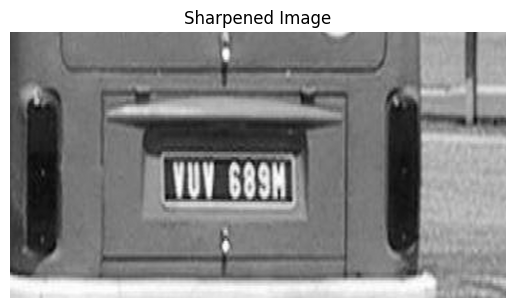

In [93]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
sharpened = cv2.filter2D(image_gray, -1, kernel)

display_image(sharpened, title="Sharpened Image")

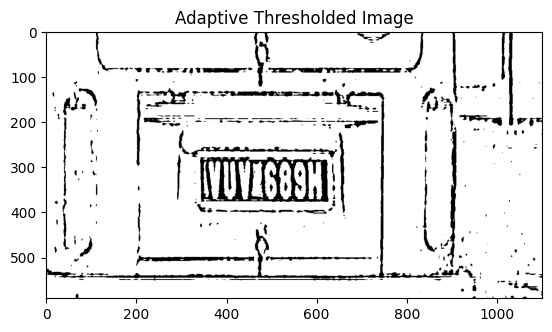

In [94]:

# Adaptive Threshold
thresh = cv2.adaptiveThreshold(sharpened, 50, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 35, 11)

# Show
plt.imshow(thresh, cmap='gray')
plt.title("Adaptive Thresholded Image")
plt.show()

In [95]:
# # Binarization
# _, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# # Show preprocessing result
# plt.imshow(thresh, cmap='gray')
# plt.title("Binarized Image")
# plt.show()

## `05` model

In [68]:
reader = easyocr.Reader(['en'], gpu= True) # this needs to run only once to load the model into memory

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [104]:
result = reader.readtext(thresh, detail=0, paragraph=True)
print(result)

['[u16OMh']


['MCIH']


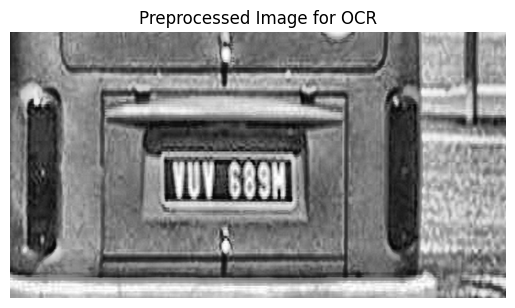

In [51]:
# Read image
image = cv2.imread("1.png", cv2.IMREAD_GRAYSCALE)

# Resize up
image = cv2.resize(image, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

# CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced = clahe.apply(image)

# Unsharp masking
blurred = cv2.GaussianBlur(enhanced, (5,5), 0)
sharpened = cv2.addWeighted(enhanced, 1.5, blurred, -0.5, 0)


result = reader.readtext(sharpened, detail=0)

print(result)

plt.imshow(sharpened, cmap='gray')
plt.title("Preprocessed Image for OCR")
plt.axis('off')
plt.show()

In [106]:
# Prepare lists for bounding boxes, confidences, class IDs, and labels
xyxy, confidences, class_ids, label = [], [], [], []

# Extract data from OCR result
for detection in result:
    bbox, text, confidence = detection[0], detection[1], detection[2]
   
    # Convert bounding box format
    x_min = int(min([point[0] for point in bbox]))
    y_min = int(min([point[1] for point in bbox]))
    x_max = int(max([point[0] for point in bbox]))
    y_max = int(max([point[1] for point in bbox]))
   
    # Append data to lists
    xyxy.append([x_min, y_min, x_max, y_max])
    label.append(text)
    confidences.append(confidence)
    class_ids.append(0)  

# Convert to NumPy arrays
detections = sv.Detections(
    xyxy=np.array(xyxy),
    confidence=np.array(confidences),
    class_id=np.array(class_ids)
)

# Annotate image with bounding boxes and labels
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=label)

# Display and save the annotated image
sv.plot_image(image=annotated_image)
cv2.imwrite("Output.jpg", annotated_image)

ValueError: invalid literal for int() with base 10: '['

In [18]:
# # config.py
# """Configuration file for license plate recognition system"""

# import os

# class Config:
#     # Data paths
#     TRAIN_DATA_DIR = "data/train"
#     TEST_DATA_DIR = "data/test"
#     MODEL_SAVE_PATH = "models/license_plate_model.pth"
#     ENGINE_EXPORT_PATH = "models/license_plate_model.engine"
    
#     # Model parameters
#     IMAGE_SIZE = (224, 224)
#     BATCH_SIZE = 32
#     EPOCHS = 100
#     LEARNING_RATE = 0.001
    
#     # Data augmentation parameters
#     AUGMENTATION_MULTIPLIER = 5
#     ROTATION_LIMIT = 15
#     BRIGHTNESS_LIMIT = 0.3
#     CONTRAST_LIMIT = 0.3
    
#     # OCR parameters
#     TESSERACT_CONFIG = '--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
#     MIN_LICENSE_PLATE_LENGTH = 5
#     MAX_LICENSE_PLATE_LENGTH = 10
    
#     # Logging
#     LOG_LEVEL = "INFO"
#     LOG_FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"

# # usage_example.py
# """Complete usage example for the license plate recognition system"""

# import cv2
# import numpy as np
# import os
# from pathlib import Path
# import logging
# from license_plate_system import LicensePlateRecognitionSystem, Config

# # Setup logging
# logging.basicConfig(level=getattr(logging, Config.LOG_LEVEL), format=Config.LOG_FORMAT)
# logger = logging.getLogger(__name__)

# def setup_data_structure():
#     """Create the recommended directory structure"""
#     directories = [
#         "data/train",
#         "data/test", 
#         "data/validation",
#         "models",
#         "results",
#         "logs"
#     ]
    
#     for directory in directories:
#         Path(directory).mkdir(parents=True, exist_ok=True)
#         logger.info(f"Created directory: {directory}")

# def prepare_sample_data():
#     """
#     Prepare sample training data structure.
#     Your data should follow this format:
    
#     data/
#     ├── train/
#     │   ├── image1.jpg
#     │   ├── image1.txt (contains: "ABC123")
#     │   ├── image2.jpg  
#     │   ├── image2.txt (contains: "XYZ789")
#     │   └── ...
#     ├── test/
#     │   ├── test1.jpg
#     │   ├── test1.txt
#     │   └── ...
#     """
    
#     sample_data_info = """
#     Data Preparation Instructions:
    
#     1. Place your license plate images in JPG format
#     2. Create corresponding TXT files with the same name
#     3. Each TXT file should contain only the license plate text (e.g., "ABC123")
#     4. Organize as follows:
    
#     data/
#     ├── train/           # Training images and labels
#     │   ├── plate001.jpg
#     │   ├── plate001.txt  → "ABC123"
#     │   ├── plate002.jpg  
#     │   ├── plate002.txt  → "XYZ789"
#     │   └── ...
#     ├── test/            # Test images and labels  
#     │   ├── test001.jpg
#     │   ├── test001.txt
#     │   └── ...
#     └── validation/      # Validation images and labels
#         ├── val001.jpg
#         ├── val001.txt
#         └── ...
#     """
    
#     print(sample_data_info)

# def train_complete_pipeline():
#     """Complete training pipeline example"""
#     logger.info("Starting license plate recognition training pipeline...")
    
#     # Initialize the system
#     lpr_system = LicensePlateRecognitionSystem()
    
#     # Check if training data exists
#     if not os.path.exists(Config.TRAIN_DATA_DIR):
#         logger.error(f"Training data directory not found: {Config.TRAIN_DATA_DIR}")
#         prepare_sample_data()
#         return
    
#     try:
#         # Train the model
#         logger.info("Training model...")
#         lpr_system.train_model(
#             data_dir=Config.TRAIN_DATA_DIR,
#             epochs=Config.EPOCHS,
#             batch_size=Config.BATCH_SIZE
#         )
        
#         # Save the trained model
#         logger.info("Saving model...")
#         lpr_system.save_model(Config.MODEL_SAVE_PATH)
        
#         # Export to engine format (optional)
#         logger.info("Exporting to TensorRT engine...")
#         try:
#             lpr_system.export_to_engine(Config.ENGINE_EXPORT_PATH)
#         except Exception as e:
#             logger.warning(f"Engine export failed: {e}. This is optional.")
        
#         logger.info("Training pipeline completed successfully!")
        
#     except Exception as e:
#         logger.error(f"Training failed: {e}")

# def test_ocr_only(image_path: str):
#     """Test OCR functionality without trained model"""
#     if not os.path.exists(image_path):
#         logger.error(f"Image not found: {image_path}")
#         return
    
#     # Load image
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#     # Initialize system (OCR only)
#     lpr_system = LicensePlateRecognitionSystem()
    
#     # Get OCR predictions
#     results = lpr_system.predict(image)
    
#     print("\n" + "="*50)
#     print(f"OCR Results for: {image_path}")
#     print("="*50)
    
#     for method, text in results.items():
#         confidence = "High" if len(text) >= Config.MIN_LICENSE_PLATE_LENGTH else "Low"
#         print(f"{method:12} | {text:15} | Confidence: {confidence}")
    
#     print("="*50)
    
#     return results

# def test_with_trained_model(image_path: str, model_path: str):
#     """Test with a trained model"""
#     if not os.path.exists(image_path):
#         logger.error(f"Image not found: {image_path}")
#         return
    
#     if not os.path.exists(model_path):
#         logger.error(f"Model not found: {model_path}")
#         return
    
#     # Initialize system and load model
#     lpr_system = LicensePlateRecognitionSystem()
#     lpr_system.load_model(model_path)
    
#     # Load and predict
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#     results = lpr_system.predict(image)
    
#     print("\n" + "="*60)
#     print(f"Complete Prediction Results for: {image_path}")
#     print("="*60)
    
#     for method, text in results.items():
#         confidence = "High" if len(text) >= Config.MIN_LICENSE_PLATE_LENGTH else "Low"
#         print(f"{method:12} | {text:15} | Confidence: {confidence}")
    
#     print("="*60)
    
#     return results

# def batch_test_directory(test_dir: str, model_path: str = None):
#     """Test all images in a directory"""
#     if not os.path.exists(test_dir):
#         logger.error(f"Test directory not found: {test_dir}")
#         return
    
#     # Initialize system
#     lpr_system = LicensePlateRecognitionSystem()
#     if model_path and os.path.exists(model_path):
#         lpr_system.load_model(model_path)
    
#     # Get all image files
#     image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
#     image_files = []
    
#     for ext in image_extensions:
#         image_files.extend(Path(test_dir).glob(f'*{ext}'))
#         image_files.extend(Path(test_dir).glob(f'*{ext.upper()}'))
    
#     if not image_files:
#         logger.error(f"No images found in {test_dir}")
#         return
    
#     results_summary = []
    
#     print(f"\nTesting {len(image_files)} images from {test_dir}")
#     print("="*80)
    
#     for image_file in image_files:
#         # Load image
#         image = cv2.imread(str(image_file))
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
#         # Predict
#         results = lpr_system.predict(image)
        
#         # Store results
#         result_entry = {
#             'filename': image_file.name,
#             'predictions': results
#         }
#         results_summary.append(result_entry)
        
#         # Print results
#         print(f"\nFile: {image_file.name}")
#         for method, text in results.items():
#             print(f"  {method:12}: {text}")
    
#     print("="*80)
#     print(f"Batch testing completed. Processed {len(image_files)} images.")
    
#     return results_summary

# def main():
#     """Main function demonstrating the complete workflow"""
#     print("License Plate Recognition System")
#     print("="*50)
    
#     # Setup directory structure
#     setup_data_structure()
    
#     # Example usage options:
    
#     # 1. OCR-only testing (no training required)
#     print("\n1. Testing OCR functionality...")
#     test_image = "test_plate.jpg"  # Replace with your test image
#     if os.path.exists(test_image):
#         test_ocr_only(test_image)
#     else:
#         print(f"Test image not found: {test_image}")
    
#     # 2. Training the complete model
#     print("\n2. Training complete model...")
#     train_complete_pipeline()
    
#     # 3. Testing with trained model
#     print("\n3. Testing with trained model...")
#     if os.path.exists(Config.MODEL_SAVE_PATH):
#         test_with_trained_model(test_image, Config.MODEL_SAVE_PATH)
    
#     # 4. Batch testing
#     print("\n4. Batch testing...")
#     if os.path.exists(Config